# Описание проекта

**Для оператора связи «Ниединогоразрыва.ком» необходимо построить алгоритм который поможет сохранить клиентов. Главной целью проекта является разработка модели прогнозирования оттока клиентов. Отток клиентов — это процесс, при котором пользователи перестают пользоваться услугами оператора и уходят к конкурентам. Цель оператора состоит в том, чтобы предсказать, какие клиенты могут уйти, и предложить им специальные условия или промокоды для удержания. Мы располагем информацией о договорах которая актуальна на 1 февраля 2020. Необходимо достичь значение метрики AUC-ROC не менее 0.88**

# План работы

- Загрузка и ознакомление с данными;
- Первичный анализ данных до объединения выборок;
- Объединение выборок;
- Предобработка данных;
- Анализ данных, подготовка и визуализация признаков;
- Анализ признаков на мультиколлинеарность;
- Проверка на дисбаланс классов;
- Разбиение выборки;
- Кодирование признаков;
- Обучение моделей, подбор гиперпараметров;
- Проверка на тестовой выборке итоговой модели;
- Анализ важности признаков;
- Построение матрицы ошибок (confusion_matrix);
- Построение ROC-кривой итоговой модели;
- Вывод;
- Отчёт по решению.

# Содержание

[Импорт библиотек](#libraries)

[Загрузка данных](#loadingdata)

[Ознакомление с данными](#familiarization)

[Объединение таблиц](#merge)

[Предобработка данных](#preprocessing)

[Анализ данных, визуализация признаков](#analysis)

[Анализ признаков на мультиколлинеарность](#multicollinearity)

[Проверка на дисбаланс классов](#imbalance)

[Разбиение выборки](#splitting)

[Кодирование признаков](#coding)

[Обучение моделей, подбор гиперпараметров](#training)

[Проверка на тестовой выборке итоговой модели](#check)

[Анализ важности признаков](#importance)

[Построение матрицы ошибок (confusion_matrix)](#confusion)

[Построение ROC-кривой итоговой модели](#roc)

[Вывод](#conclusion)

[Отчёт по решению](#report)

**Импорт библиотек** <a id='libraries'></a>

In [ ]:
!pip install scikit-learn==1.1

In [ ]:
!pip install phik

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import phik

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import catboost as cb
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
RANDOM_STATE = 110923

**Загрузка данных** <a id='loadingdata'></a>

In [ ]:
data_files = ['contract_new.csv', 'personal_new.csv', 'internet_new.csv', 'phone_new.csv']
data = {}

data_dir = '/datasets/'

for file_name in data_files:
    file_path = os.path.join(data_dir, file_name)
    data_name = os.path.splitext(file_name)[0]
    data[data_name] = pd.read_csv(file_path)

contract_df = data['contract_new']
personal_df = data['personal_new']
internet_df = data['internet_new']
phone_df = data['phone_new']

**Ознакомление с данными** <a id='familiarization'></a>

In [ ]:
data_tables = [contract_df, personal_df, internet_df, phone_df]
table_names = ['Contract Data', 'Personal Data', 'Internet Data', 'Phone Data']

for table, name   in zip(data_tables, table_names):
    print(f"Информация о таблице: {name}")
    print(table.info())
    print("\nСтатистическое описание:")
    print(table.describe())
    print("\nНазвания столбцов:")
    print(table.columns)

    missing_values = table.isna().sum()
    print("\nПропущенные значения:")
    print(missing_values)

    unique_counts = table.nunique()
    print("\nКоличество уникальных значений:")
    print(unique_counts)

    duplicate_count = table.duplicated().sum()
    print(f"\nКоличество дубликатов: {duplicate_count}\n")

    print("\n" + "=" * 50 + "\n")


Информация о таблице: Contract Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Статистическое описание:
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

Названия столбцов:
Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'Paym

- Таблицы отличаются кол-ом строк, однако, пропуски и дубликаты отсутствуют. Кроме численных значений имеем также категориальные. Далее, в результате объединения таблиц, где было меньше строк, будут пропущенные значения в соответствующих столбцах, к работе с пропусками ещё придётся вернуться. Возможно, у нас имеются неявные дубликаты, что также стоит проверить.

In [ ]:
contract_df.head()

customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

In [ ]:
personal_df.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [ ]:
internet_df.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [ ]:
phone_df.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

- Вывод первых строк даёт нам не особо много информации, визуализируем данные.

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contract_df['MonthlyCharges'], bins=40, kde=True)
plt.title('Распределение ежемесячных платежей в Contract Data')
plt.xlabel('Ежемесячные платежи')
plt.ylabel('Частота')
plt.show()

- В данном случае, можно заметить, что наибольшая сумма платежей в начале действия договора, вероятно, что при заключении договора на обслуживание, пользователь оплачивает сразу несколько месяцев обслуживания или подключает доп. услуги; после чего есть спад и далее, платежи распределяются примерно равно в течении срока договора.

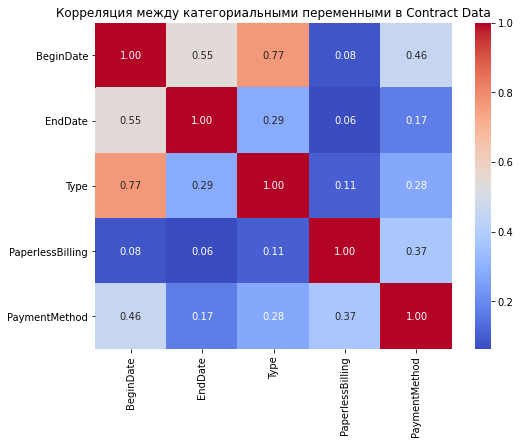

In [ ]:
contract_df_no_id = contract_df.drop(columns=['customerID', 'MonthlyCharges', 'TotalCharges'])
phik_corr_matrix_contract = contract_df_no_id.phik_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(phik_corr_matrix_contract, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между категориальными переменными в Contract Data')
plt.show()

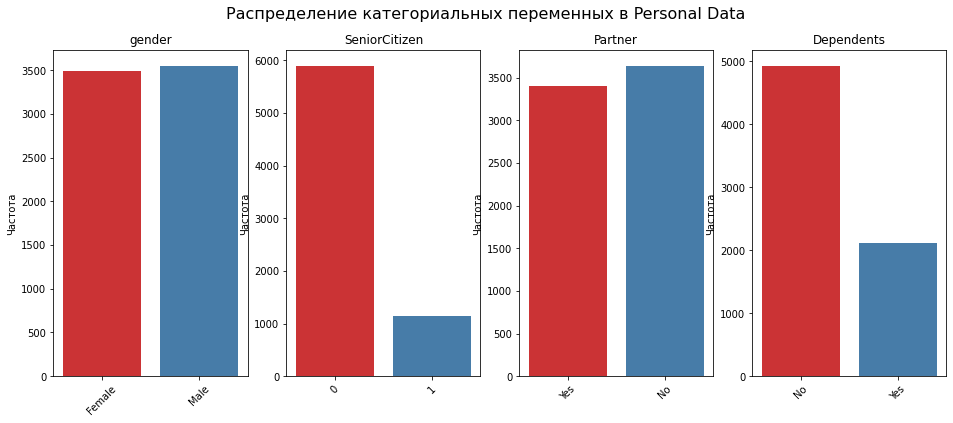

In [ ]:
categorical_cols_personal = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))
fig.subplots_adjust(hspace=0.5)

plt.suptitle('Распределение категориальных переменных в Personal Data', fontsize=16)

for i, col in enumerate(categorical_cols_personal):
    ax = axes[i]
    sns.countplot(data=personal_df, x=col, palette='Set1', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Частота')
    ax.tick_params(axis='x', rotation=45)

plt.show()

interval columns not set, guessing: ['SeniorCitizen']


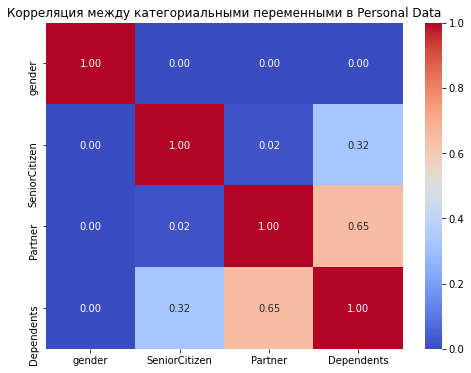

In [ ]:
personal_df_no_id = personal_df.drop(columns=['customerID'])
phik_corr_matrix_personal = personal_df_no_id.phik_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(phik_corr_matrix_personal, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между категориальными переменными в Personal Data')
plt.show()

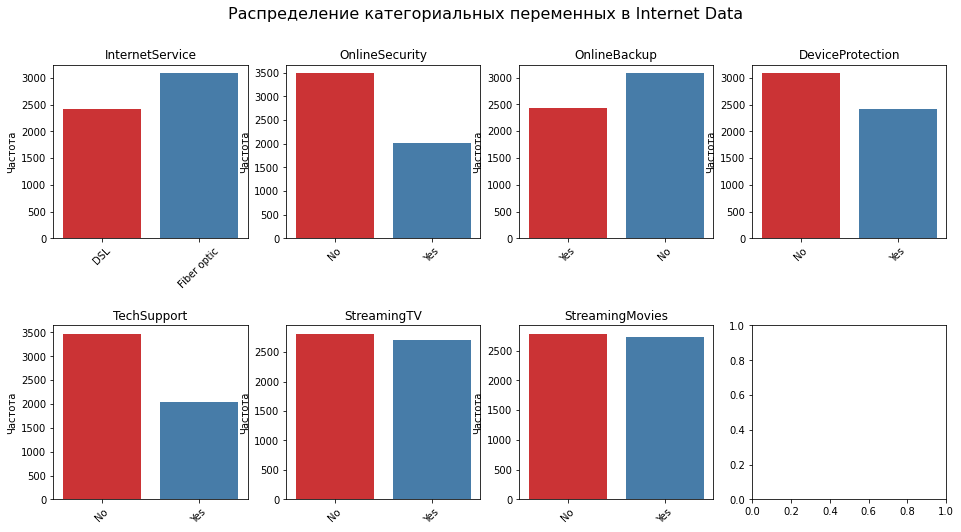

In [ ]:
categorical_cols_internet = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

plt.suptitle('Распределение категориальных переменных в Internet Data', fontsize=16)

for i, col in enumerate(categorical_cols_internet):
    row = i // 4
    col_num = i % 4
    ax = axes[row, col_num]
    sns.countplot(data=internet_df, x=col, palette='Set1', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Частота')
    ax.tick_params(axis='x', rotation=45)

plt.show()

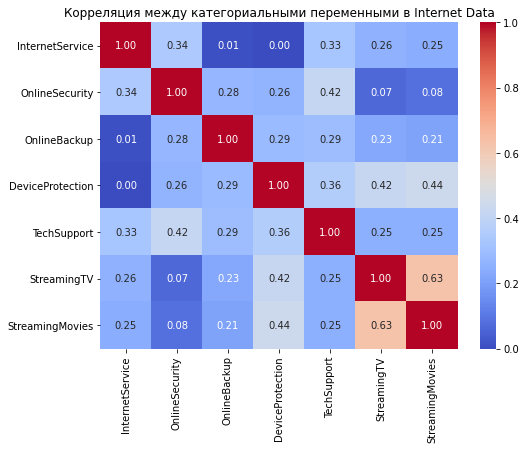

In [ ]:
internet_df_no_id = internet_df.drop(columns=['customerID'])
phik_corr_matrix_internet = internet_df_no_id.phik_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(phik_corr_matrix_internet, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между категориальными переменными в Internet Data')
plt.show()

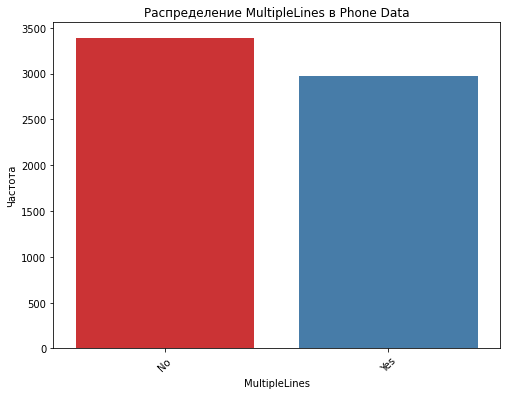

In [ ]:
categorical_cols_phone = ['MultipleLines']
for col in categorical_cols_phone:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=phone_df, x=col, palette='Set1')
    plt.title(f'Распределение {col} в Phone Data')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()

- Данные распределены равномерно, больше всего выбивается "SeniorCitizen", "Dependents", "OnlineSecurity" и "TechSupport". С корреляцией пока не всё так явно. Думаю, стоит двигаться дальше по плану работ.

**Объединение таблиц** <a id='merge'></a>

In [ ]:
df = pd.merge(contract_df, personal_df, on='customerID', how='outer')
df = pd.merge(df, internet_df, on='customerID', how='outer')
df = pd.merge(df, phone_df, on='customerID', how='outer')

In [ ]:
df.head()

customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  gender  \
0           Electronic check           29.85        31.04  Female   
1               Mailed check           56.95      2071.84    Male   
2               Mailed check           53.85       226.17    Male   
3  Bank transfer (automatic)           42.30       1960.6    Male   
4           Electronic check           70.70        353.5  Female   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0              0     Yes         No             DSL             No   
1              0      No         No             DSL            Yes   
2              0      No         No             DSL            Yes   
3              0      No         No             DSL            Yes   
4              0      No         No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [ ]:
df.describe()

MonthlyCharges  SeniorCitizen
count     7043.000000    7043.000000
mean        64.761692       0.162147
std         30.090047       0.368612
min         18.250000       0.000000
25%         35.500000       0.000000
50%         70.350000       0.000000
75%         89.850000       0.000000
max        118.750000       1.000000

In [ ]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

- В результате объединения таблиц, как и ожидалось, в ряде столбцов мы получили пропуски. Необходимо провести работу с пропусками в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines.

**Предобработка данных** <a id='preprocessing'></a>

- Сразу приведём значения в данных к нижнему регистру и проверим на неявные дубликаты.

In [ ]:
def low_col(column_el):
    return str.lower('_'.join(re.sub(r"([A-Z])", r" \1", column_el).split()))

In [ ]:
df.columns = map(low_col, df.columns)

In [ ]:
text_columns = df.select_dtypes(include=['object']).columns

df[text_columns] = df[text_columns].apply(lambda x: x.str.lower())

df[text_columns] = df[text_columns].apply(lambda x: x.str.strip())

duplicate_count = df.duplicated().sum()
print(f"Количество неявных дубликатов: {duplicate_count}")

Количество неявных дубликатов: 0


In [ ]:
df['internet_service'].unique()

array(['dsl', 'fiber optic', nan], dtype=object)

- У нас есть значения 'DSL': Digital Subscriber Line (цифровая абонентская линия). Тип интернет-сервиса использует обычные телефонные линии для передачи данных и 'Fiber optic' этот тип интернет-сервиса использует оптоволоконные кабели для передачи данных.

In [ ]:
internet_related_cols = ['internet_service', 'online_security', 'online_backup', 'device_protection',
                         'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']

for col in internet_related_cols:
    missing_count = df[df[col].isna()].shape[0]
    print(f"Количество пропусков в столбце {col}: {missing_count}")

Количество пропусков в столбце internet_service: 1526
Количество пропусков в столбце online_security: 1526
Количество пропусков в столбце online_backup: 1526
Количество пропусков в столбце device_protection: 1526
Количество пропусков в столбце tech_support: 1526
Количество пропусков в столбце streaming_t_v: 1526
Количество пропусков в столбце streaming_movies: 1526
Количество пропусков в столбце multiple_lines: 682


- Выходит так, что столбец InternetService в какой-то степени является начальной точкой из которой уже выходит ряд услуг связанных с интернет подключением OnlineSecurity (Онлайн-безопасность), OnlineBackup (Онлайн-резервное копирование), DeviceProtection (Защита устройства), StreamingTV (Потоковое телевидение), StreamingMovies (Потоковое видео) и TechSupport (Техподдержка). По данным столбцам, я считаю правильным поставить "заглушку", поскольку заполнив InternetService конкретным значением 'DSL' или 'Fiber optic' из этого выходит, что мы по умолчанию предполагаем, что человек использует интернет и адекватно заполнить дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies у нас не удастся и в конечном счёте только исказим данные. Как исключение, здесь считаю столбец MultipleLines (наличие возможности ведения параллельных линий во время звонка). MultipleLines не относится напрямую к пользованию интернетом. Как итогог, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV и StreamingMovies заполнить 'no_internet' - будем считать что услуги не используются; на счёт TechSupport, клиент может обратиться в поддержку не только по вопросам связанным с интернетом, но и с вопросом плохой связи, помехами во время звонка, например, но поскольку у нас идёт ровное совпадение по кол-ву пропусков в столбцах связанных с интернетом, я предположу, что данный столбец относится только к данным услугам, по этому пропуски заполним 'no_internet'.

In [ ]:
df[['multiple_lines', 'internet_service']].head(10)

multiple_lines internet_service
0            NaN              dsl
1             no              dsl
2             no              dsl
3            NaN              dsl
4             no      fiber optic
5            yes      fiber optic
6            yes      fiber optic
7            NaN              dsl
8            yes      fiber optic
9             no              dsl

- С MultipleLines всё немного иначе, можно заметить, что при условии использования интернета, у пользователя может быть подключена, а может быть и нет, услуга по ведению параллельных линий во время звонка. Думаю, стоит посмотреть, на каждом ли типе InternetService доступна данная функция.

In [ ]:
pivot_table = df[df['internet_service'] == 'dsl'] \
.pivot_table(index='internet_service', columns='multiple_lines', aggfunc='size', fill_value=0)

print(pivot_table)

multiple_lines      no  yes
internet_service           
dsl               1048  691


In [ ]:
pivot_table = df[df['internet_service'] == 'fiber optic'] \
.pivot_table(index='internet_service', columns='multiple_lines', aggfunc='size', fill_value=0)

print(pivot_table)

multiple_lines      no   yes
internet_service            
fiber optic       1158  1938


- От типа InternetService это не зависит, в таком случае, заполним пропуски заглушкой - 'no_phone'. В итоге мы заполним всё, что связано с интернетом 'no_internet', а MultipleLines 'no_phone'. Использование разных заглушек, которые логически соответствуют отсутствию услуг, может улучшить производительность модели и сделать прогнозы более реалистичными.

In [ ]:
columns_to_internet = ['internet_service', 'online_security', 'online_backup',
                   'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies']

for column in columns_to_internet:
    df[column].fillna('no_internet', inplace=True)

In [ ]:
df['multiple_lines'].fillna('no_phone', inplace=True)

In [ ]:
df.isna().sum()

customer_i_d         0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
multiple_lines       0
dtype: int64

- Перейдём к типам данных, столбец TotalCharges имеет тип данных object, стоит привести его к float как и столбец MonthlyCharges.

In [ ]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

In [ ]:
df.isna().sum()

customer_i_d          0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_t_v         0
streaming_movies      0
multiple_lines        0
dtype: int64

- Оказалось, что у нас было 11 строк, где в TotalCharges был просто пробел. Для данных строк нам неизвестна дата окончания договора, т.е. это ещё активный пользователь, в связи с чем, рассчитать срок действия договора и заполнить TotalCharges мы не сможем. Можно конечно использовать заполнение средним/медианой, но учитывая количество строк, лучше просто их удалить.

In [ ]:
df.dropna(subset=['total_charges'], inplace=True)

- Признак SeniorCitizen с типом данных int64, хотя принимает только два значения и используется для обозначения категории пользователей, его можно рассматривать как бинарный, в этом случае, можно изменить его тип данных на object для удобства.

In [ ]:
df['senior_citizen'] = df['senior_citizen'].astype('object')

- BeginDate и EndDate также имеют тип object, стоит преобразовать их в формат дат и т.к. мы дошли до даты, создать целевой признак и создать новый, который будет содержать информацию о сроке пользования услугами.

In [ ]:
df['end_date'] = df['end_date'].replace('no', '2020-02-01')

In [ ]:
df['churn'] = np.where(df['end_date'] == '2020-02-01', 0, 1)

In [ ]:
df[['end_date', 'begin_date']] = df[['end_date', 'begin_date']].astype("datetime64[ns]")

In [ ]:
df['tenure'] = (df.end_date - df.begin_date).dt.days

In [ ]:
df = df.drop(['end_date', 'begin_date'], axis=1)

- Все значения 'no' в 'end_date' заменили на '2020-02-01', т.е. дату выгрузки и создали целевой признак 'churn', который содержит информацию о том, ушёл пользователь или нет. Изменили тип данных в даты и создали новый признак 'tenure', который содержит информацию о сроке действия договора. Поскольку у нас есть информация о сроке использользования продукта и о том ушёл пользователь или нет, столбцы 'end_date' и 'begin_date' нам больше не нужны.

- Далее, попробуем добавить признак, который будет определять тип (выше/ниже средней) оплаты исходя из суммы ежемесячного платежа.

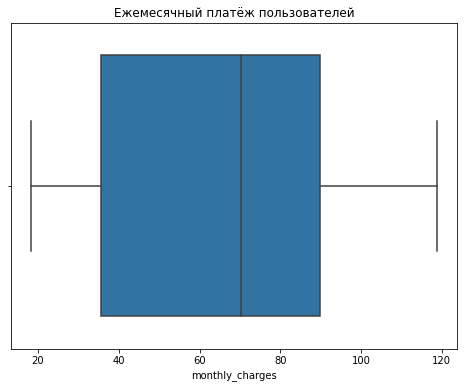

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='monthly_charges')
plt.title('Ежемесячный платёж пользователей')
plt.show()

In [ ]:
Q1 = df['monthly_charges'].quantile(0.25)
Q3 = df['monthly_charges'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
IQR

54.275

In [ ]:
df['monthly_charges'].mean()

64.79820819112628

In [ ]:
df['monthly_charges'].median()

70.35

- Поскольку выбросы в данном случае отсутствуют, за основу возьмём среднее значение.

In [ ]:
mean_monthly_charges = df['monthly_charges'].mean()

df['monthly_charges_type'] = df['monthly_charges'].apply(lambda x: 'low' if x < mean_monthly_charges else 'high')

- И удаляем столбец customerID так как для обучения модели он не потребуется.

In [ ]:
df.drop('customer_i_d', axis=1, inplace=True)

- Таблицы объединили, провели предобработку с заполнением пропущенных значений, изменением типов данных, а также создали целевой признак и два новых признака Tenure и MonthlyChargesType. Было удалено 11 строк и столбцы 'end_date' и 'begin_date'. Дубликаты отсутствую, думаю, с предобработкой можно закончить и перейти к следующему этапу.

**Анализ данных, визуализация признаков.** <a id='analysis'></a>

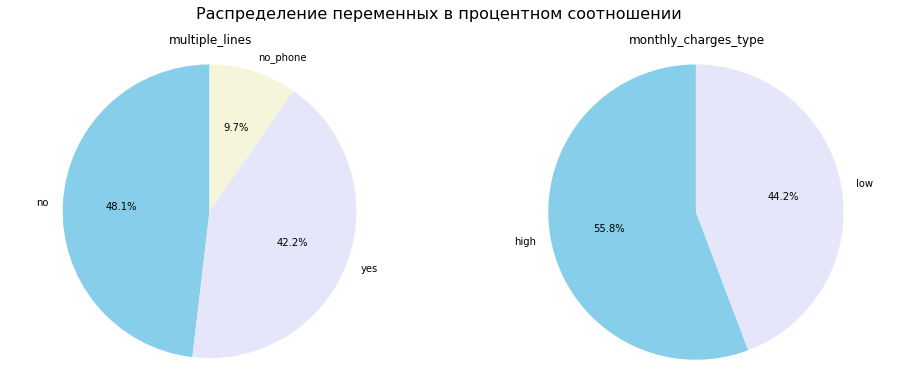

In [ ]:
pie_category = ['multiple_lines', 'monthly_charges_type']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.subplots_adjust(hspace=0.5)

plt.suptitle('Распределение переменных в процентном соотношении', fontsize=16)

for i, col in enumerate(pie_category):
    ax = axes[i]
    counts = df[col].value_counts()
    labels = counts.index
    sizes = counts.values
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'Lavender', 'Beige'])
    ax.set_title(col)
    ax.axis('equal')

plt.show()

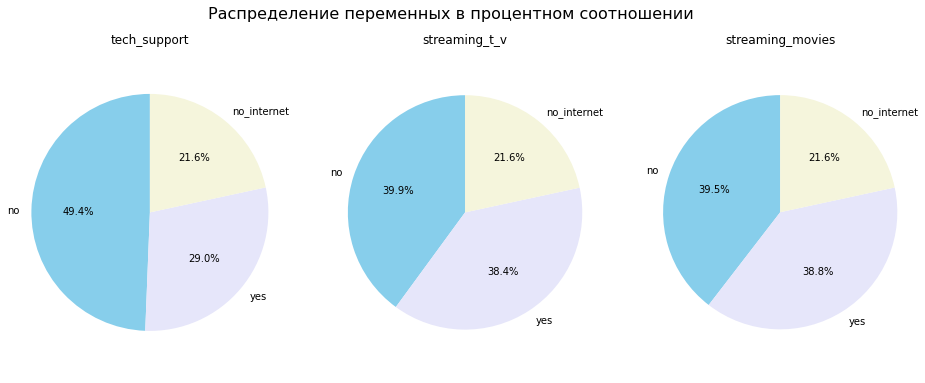

In [ ]:
pie_category = ['tech_support', 'streaming_t_v', 'streaming_movies']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
fig.subplots_adjust(hspace=0.5)

plt.suptitle('Распределение переменных в процентном соотношении', fontsize=16)

for i, col in enumerate(pie_category):
    ax = axes[i]
    counts = df[col].value_counts()
    labels = counts.index
    sizes = counts.values
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'Lavender', 'Beige'])
    ax.set_title(col)
    ax.axis('equal')

plt.show()

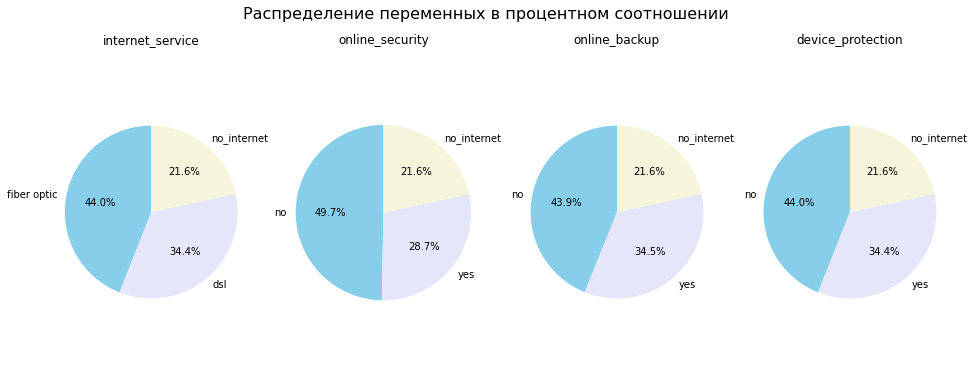

In [ ]:
pie_category = ['internet_service', 'online_security', 'online_backup', 'device_protection']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))
fig.subplots_adjust(hspace=0.5)

plt.suptitle('Распределение переменных в процентном соотношении', fontsize=16)

for i, col in enumerate(pie_category):
    ax = axes[i]
    counts = df[col].value_counts()
    labels = counts.index
    sizes = counts.values
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'Lavender', 'Beige'])
    ax.set_title(col)
    ax.axis('equal')

plt.show()

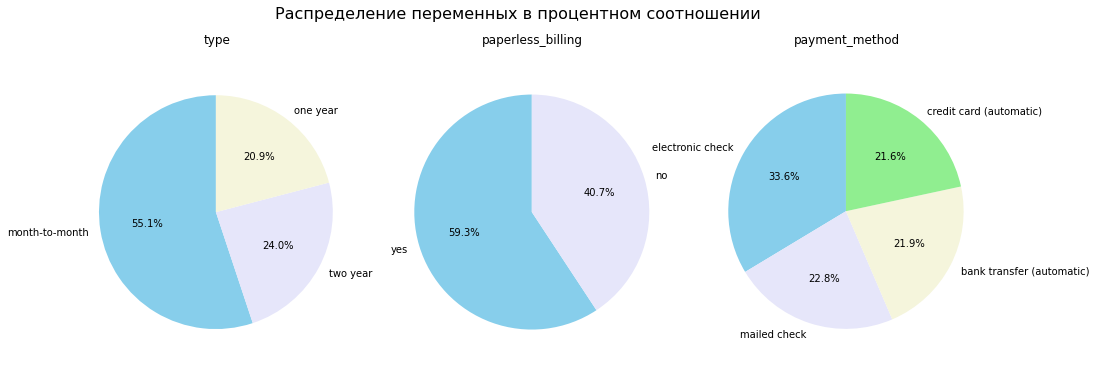

In [ ]:
pie_category = ['type', 'paperless_billing', 'payment_method']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
fig.subplots_adjust(hspace=0.5)

plt.suptitle('Распределение переменных в процентном соотношении', fontsize=16)

for i, col in enumerate(pie_category):
    ax = axes[i]
    counts = df[col].value_counts()
    labels = counts.index
    sizes = counts.values
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'Lavender', 'Beige', 'Lightgreen'])
    ax.set_title(col)
    ax.axis('equal')

plt.show()

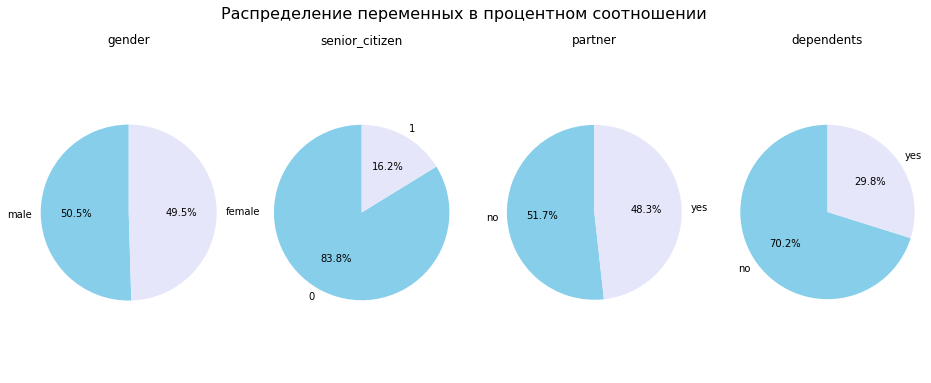

In [ ]:
pie_category = ['gender', 'senior_citizen', 'partner', 'dependents']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))
fig.subplots_adjust(hspace=0.5)

plt.suptitle('Распределение переменных в процентном соотношении', fontsize=16)

for i, col in enumerate(pie_category):
    ax = axes[i]
    counts = df[col].value_counts()
    labels = counts.index
    sizes = counts.values
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'Lavender'])
    ax.set_title(col)
    ax.axis('equal')

plt.show()

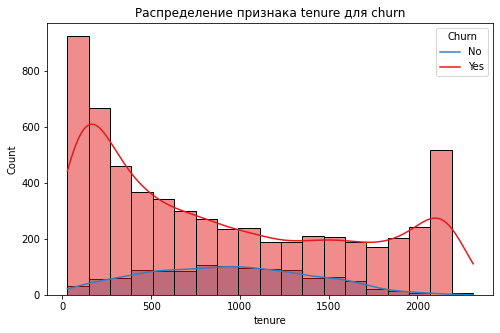

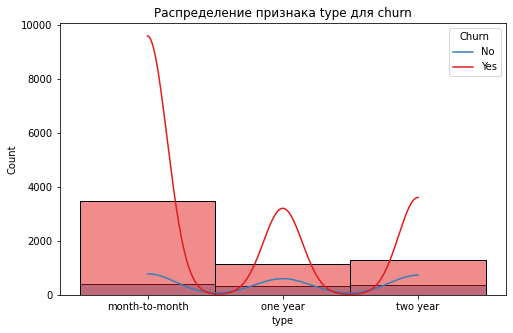

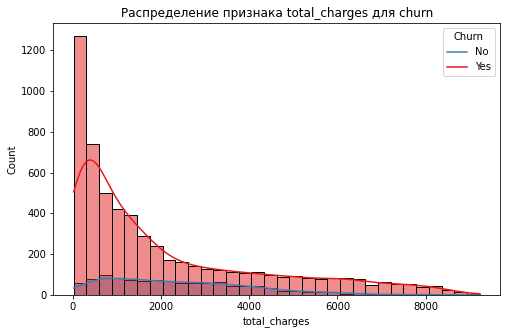

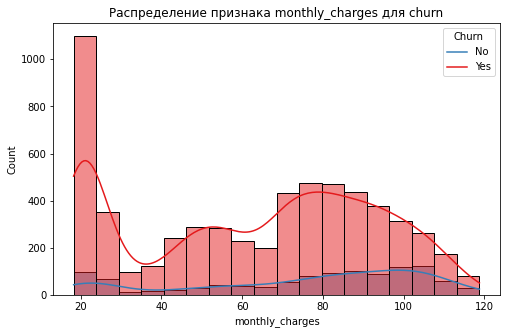

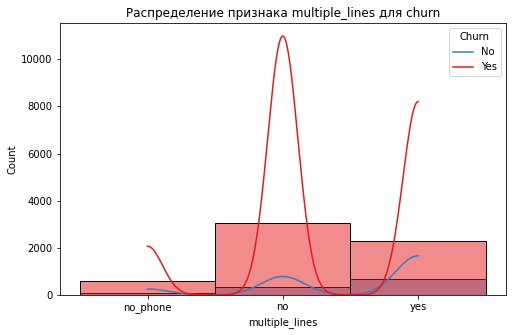

In [ ]:
selected_features = ['tenure', 'type', 'total_charges', 'monthly_charges', 'multiple_lines']

for feature in selected_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=feature, hue="churn", kde=True, palette="Set1")
    plt.title(f'Распределение признака {feature} для churn')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Churn', labels=['No', 'Yes'])
    plt.show()

- На графиках приведённых выше можно увидеть распределение различных признаков. В нашей выборке почти равно кол-во мужчин и женщин; достаточно маленько кол-во граждан имеющих статут пенсионера по возрасту; наличие супруги (супруга) также делится почти поровну; у большинства пользователей нет детей; большинство использует ежемесячный тип оплаты и гораздо реже используется годовой и двухгодовой; более чем половине пользователей необходим электронный платёжный документ; способы оплаты разделяются "почти" в равных соотношениях; не так много людей используют интернет сервисы; с небольшим перевесом часть пользователей вносит платёж выше среднего; наличие ведение параллельных линий, является достаточно популярной услугой.

**Анализ признаков на мультиколлинеарность** <a id='multicollinearity'></a>

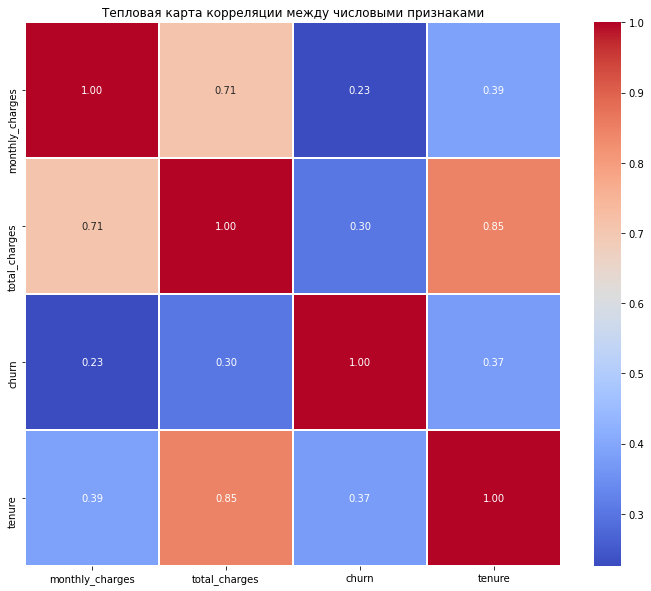

In [ ]:
numerical_features = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_features.phik_matrix(interval_cols=numerical_features.columns)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Тепловая карта корреляции между числовыми признаками')
plt.show()

interval columns not set, guessing: ['churn']


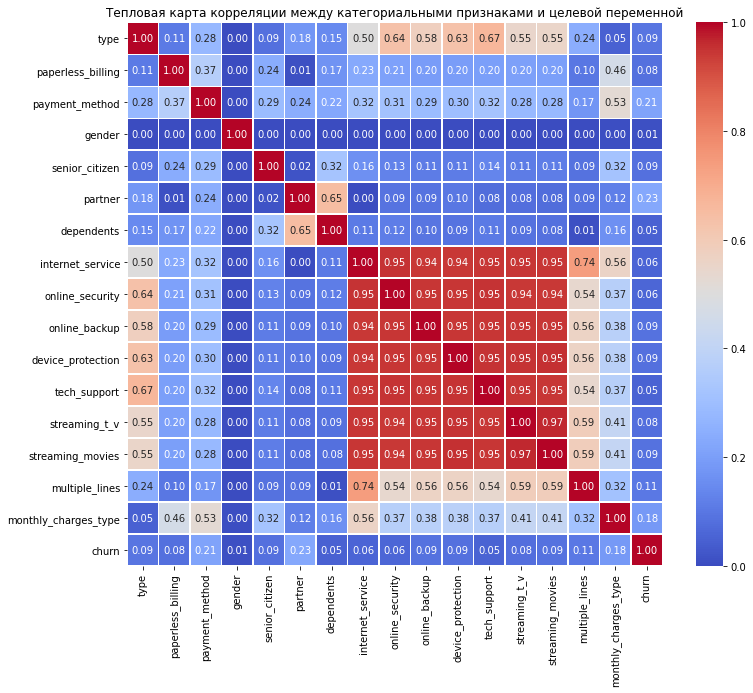

In [ ]:
categorical_cols = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
                    'partner', 'dependents', 'internet_service', 'online_security', 'online_backup',
                    'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies',
                    'multiple_lines', 'monthly_charges_type', 'churn']

correlation_matrix = df[categorical_cols].phik_matrix()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Тепловая карта корреляции между категориальными признаками и целевой переменной')
plt.show()

- Наибольшая корреляция наблюдается между дополнительными онлайн услугами, в целом так и есть, мы видели это при заполнении пропусков, использование InternetService напрямую связано с OnlineSecurity,	OnlineBackup, DeviceProtection, TechSupport,	StreamingTV и StreamingMovies данные признаки почти равнозначны. Мы можем использовать метод регуляризации или понижения размерности, но в данном случае, мне кажется будет лучше удалить данные признаки и оставить только InternetService как факт того, использует пользователь онлайн сервисы или нет. В числовых признаках 'total_charges' и 'tenure' имеют значение 0.82, изначально предполагал взять за максимальную границу значение 0.8, но поскольку превышение небольшое, пока оставлю так, возможно, к этом придётся вернуться позже.

In [ ]:
columns_to_drop = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies']
df.drop(columns=columns_to_drop, inplace=True)

interval columns not set, guessing: ['churn']


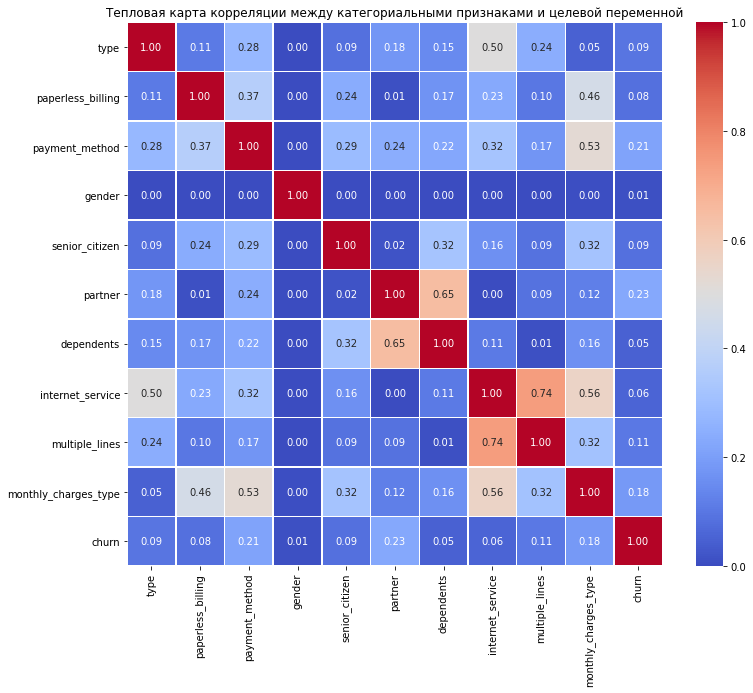

In [ ]:
categorical_cols = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
                    'partner', 'dependents', 'internet_service',
                    'multiple_lines', 'monthly_charges_type', 'churn']

correlation_matrix = df[categorical_cols].phik_matrix()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Тепловая карта корреляции между категориальными признаками и целевой переменной')
plt.show()

**Проверка на дисбаланс классов** <a id='imbalance'></a>

- Определим features и target.

In [ ]:
features = df.drop(['churn'], axis=1)

In [ ]:
target = df['churn']

In [ ]:
class_counts = target.value_counts()
print(class_counts)

0    5931
1    1101
Name: churn, dtype: int64


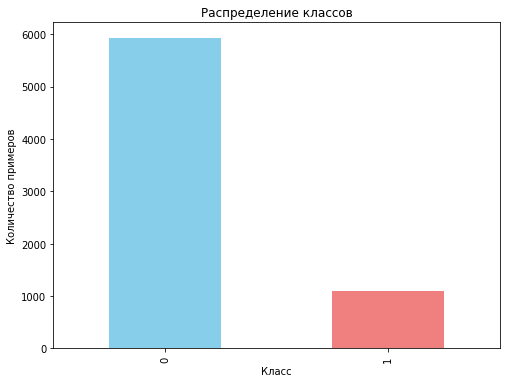

In [ ]:
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество примеров')
plt.show()

- У нас явный дисбаланс классов, но поскольку ROC-AUC не чувствителен к дисбалансу, балансировать выборки не будем и пойдём дальше.

**Разбиение выборки** <a id='splitting'></a>

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
features_train.shape[0]

5274

In [ ]:
features_test.shape[0]

1758

In [ ]:
target_train.shape[0]

5274

In [ ]:
target_test.shape[0]

1758

**Кодирование признаков** <a id='coding'></a>

- Выбираем  столбцы из features_train, которые содержат данные типа "object", которые нужно закодировать с помощью метода One-Hot Encoding (OHE) и столбцы из features_train, которые не содержат данные типа "object" для стандартизции с использованием StandardScaler.

In [ ]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

- Создаём ColumnTransformer с преобразованиями для числовых (num) и категориальных (cat) признаков. ColumnTransformer будет использоваться внутри пайплайна для предварительной обработки данных. Затем создаём Pipeline и param_grid где содержатся параметры и значения для моделей, которые будут использоваться для поиска оптимальной модели через кросс-валидацию.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), ohe_features)
    ])

pipeline = Pipeline([
    ('scaler', preprocessor),
    ('model', None)
]
)


param_grid = [
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'model__C': np.logspace(-3,3,20),
        'model__penalty': ["l1", "l2"]
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__criterion': ['gini','entropy'],
        'model__max_depth': range(1, 6)
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': range(10, 101, 20),
        'model__max_depth': range(1, 6)
    },
    {
        'model': [cb.CatBoostClassifier(random_state=RANDOM_STATE)],
        'model__learning_rate': [0.01, 0.03, 0.001],
        'model__depth': range(1, 6)
    }
]

**Обучение моделей, подбор гиперпараметров** <a id='training'></a>

- Задаём функцию которая выводит информацию о модели, её наилучших параметрах и оценке качества модели на основе ROC-AUC.

In [ ]:
def result(model, name):
    print(f''
          f'Модель {name}:\n' \
           f'Параметры: {model.best_params_}\n' \
           f'ROC-AUC: {model.best_score_}')

- interaction_only будет генерировать только признаки, которые представляют собой произведения исходных признаков друг на друга.

In [ ]:
interaction_only=True

- Выполняем поиск по сетке Grid Search.

In [ ]:
grid_pipe = GridSearchCV(pipeline,
                         param_grid,
                         cv = 3,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose= False)
grid_pipe.fit(features_train, target_train)

0:	learn: 0.6868305	total: 47.2ms	remaining: 47.1s
1:	learn: 0.6808139	total: 48.4ms	remaining: 24.1s
2:	learn: 0.6747780	total: 49.4ms	remaining: 16.4s
3:	learn: 0.6685024	total: 50.4ms	remaining: 12.5s
4:	learn: 0.6630332	total: 51.2ms	remaining: 10.2s
5:	learn: 0.6574018	total: 51.9ms	remaining: 8.6s
6:	learn: 0.6519378	total: 52.7ms	remaining: 7.48s
7:	learn: 0.6463596	total: 53.5ms	remaining: 6.64s
8:	learn: 0.6410991	total: 54.3ms	remaining: 5.98s
9:	learn: 0.6363761	total: 55ms	remaining: 5.45s
10:	learn: 0.6307690	total: 55.9ms	remaining: 5.03s
11:	learn: 0.6262756	total: 56.5ms	remaining: 4.65s
12:	learn: 0.6211431	total: 57ms	remaining: 4.33s
13:	learn: 0.6163322	total: 57.7ms	remaining: 4.06s
14:	learn: 0.6114106	total: 58.4ms	remaining: 3.83s
15:	learn: 0.6069219	total: 59ms	remaining: 3.63s
16:	learn: 0.6026402	total: 60.1ms	remaining: 3.47s
17:	learn: 0.5982440	total: 61ms	remaining: 3.33s
18:	learn: 0.5938511	total: 62ms	remaining: 3.2s
19:	learn: 0.5898231	total: 62.8ms

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'tenure']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'multiple_lines',
                                                                          'monthly_charges_type'])])),
                                       (...
                          'model__criterion': ['gini', 'entropy'],
                          'model__max_depth': range(1, 6)},
                         {'model': [RandomForestClassifier(random_state=110923)],
                          'model__max_depth': range(1, 6),
                          'model__n_estimators': range(10, 101, 20)},
                         {'model': [<catboost.core.CatBoostClassifier object at 0x7faeaad74a30>],
                          'model__depth': range(1, 6),
                          'model__learning_rate': [0.01, 0.03, 0.001]}],
             scoring='roc_auc', verbose=False)

- Вызвываем функцию result.

In [ ]:
result(grid_pipe, 'CatBoostClassifier')

Модель CatBoostClassifier:
Параметры: {'model': <catboost.core.CatBoostClassifier object at 0x7faeaad74a30>, 'model__depth': 5, 'model__learning_rate': 0.03}
ROC-AUC: 0.891057426897868


- Лучше всего себя показала модель CatBoostClassifier, со значением метрики ROC-AUC: 0.8910.

**Проверка на тестовой выборке итоговой модели** <a id='check'></a>

In [ ]:
best_model = cb.CatBoostClassifier(random_state=RANDOM_STATE, depth= 5, \
                                   learning_rate = 0.03, cat_features=ohe_features, verbose = False)
best_model.fit(features_train, target_train)

print(f'Accuracy: {accuracy_score(best_model.predict(features_test), target_test)}')
print(f'ROC-AUC: {roc_auc_score(target_test, best_model.predict_proba(features_test)[:, 1])}')

Accuracy: 0.8919226393629124
ROC-AUC: 0.903894112714859


- На тестовой выборке получаем значения Accuracy: 0.8919 и ROC-AUC: 0.9038. Целью была поставлена задача, достичь показателя не менее 0.88 с чем мы справились.

**Анализ важности признаков** <a id='importance'></a>

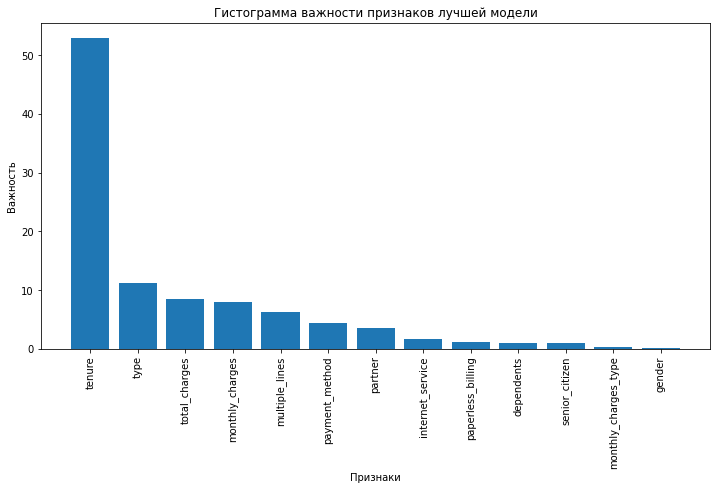

In [ ]:
feature_importance = best_model.feature_importances_

importance_df = pd.DataFrame({'Feature': features_train.columns, 'Importance': feature_importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Гистограмма важности признаков лучшей модели')
plt.show()

- Наименьшее значение у признака 'gender', также почти ничего нам не даёт ранее созданный признак 'monthly_charges_type'. Больше всего оказались значимы: 'tenure', 'type', 'total_charges', 'monthly_charges', 'multiple_lines'. Что касается этих признаков 'total_charges', 'monthly_charges', вероятно, всё же стоило оставить только 'monthly_charges', информации о ежемесячном платеже с учётом доступной информации и сроке использования договора, нам было бы достаточно.

**Построение матрицы ошибок (confusion_matrix)**  <a id='confusion'></a>

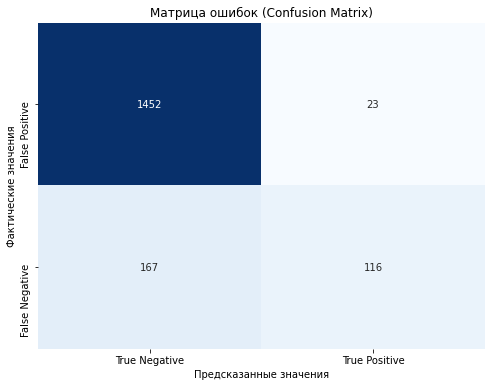

In [ ]:
y_pred = best_model.predict(features_test)

conf_matrix = confusion_matrix(target_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['True Negative', 'True Positive'],
            yticklabels=['False Positive', 'False Negative'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.title('Матрица ошибок (Confusion Matrix)')

plt.show()

- значение True Negative - 1452, модель хорошо предсказывает пользователей, которые не уйдут.
- значение True Positive - 116, модель хорошо предсказывает пользователей, которые на самом деле не уйдут.
- Значение False Positive - 21, модель не так сильно ошибается в предсказании пользователей, которые уйдут.
- значение False Negative - 167, модель иногда делает предсказание, что пользователь уйдёт, хотя это не так.

**Построение ROC-кривой итоговой модели** <a id='roc'></a>

In [ ]:
y_pred_proba = grid_pipe.predict_proba(features_test)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, y_pred_proba)
roc_auc = roc_auc_score(target_test, y_pred_proba)

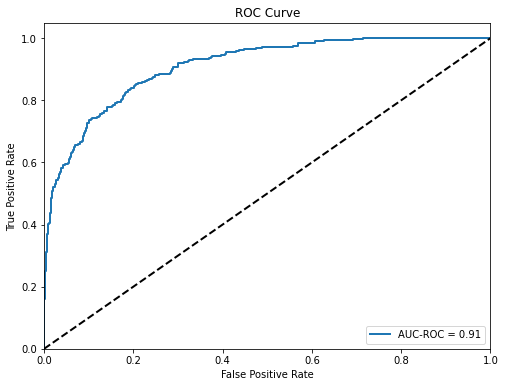

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

- AUC-ROC = 91 - это хороший результат и который указывает нам на то, что модель хорошо справляется с задачей бинарной классификации и имеет высокую способность различать классы (True Positive и False Positive).

**Вывод** <a id='conclusion'></a>

Был построен алгоритм для оператора связи «Ниединогоразрыва.ком» который поможет сохранить клиентов. Модель способна прогнозировать отток клиентов, что поможет оператору определить и удержать клиентов которые решили уйти. Удалось достичь метрики AUC-ROC 0.9038 на тестовой выборке, что соответствует запросу.

В ходе работы были выполнены следующие этапы:
- Загрузка и ознакомление с данными;
- Первичный анализ данных до объединения выборок;
- Объединение выборок;
- Предобработка данных;
- Анализ данных, подготовка и визуализация признаков;
- Анализ признаков на мультиколлинеарность;
- Проверка на дисбаланс классов;
- Разбиение выборки;
- Кодирование признаков;
- Обучение моделей, подбор гиперпараметров;
- Проверка на тестовой выборке итоговой модели;
- Анализ важности признаков;
- Построение матрицы ошибок (confusion_matrix);
- Построение ROC-кривой итоговой модели;
- Итоговый отчёт.

Был проведён первичный анализ данных, с последующим объединением в единую таблицу, которая была подготовлена к анализу и построению модели. Часть признаков была удалена, но взамен были созданы новые. В ходе работы использовались модели: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier - который показал себя лучше всего. Кроме того данные были проанализированы на дисбаланс классов, мультиколлинеарность и анализ важности признаков, были построены и проанализированы матрицы ошибок и ROC-кривая для итоговой модели. В целом, работы выполнялась по изначально намеченному плану, что позволило выполнить задачу по достижению для заказчика необходимого показателя качества модели.

**Отчёт по решению** <a id='report'></a>

Были выполнены все пункты изначально намеченного плана, а именно:

- Загрузка и ознакомление с данными;
- Первичный анализ данных до объединения выборок;
- Объединение выборок;
- Предобработка данных;
- Анализ данных, подготовка и визуализация признаков;
- Анализ признаков на мультиколлинеарность;
- Проверка на дисбаланс классов;
- Разбиение выборки;
- Кодирование признаков;
- Обучение моделей, подбор гиперпараметров;
- Проверка на тестовой выборке итоговой модели;
- Анализ важности признаков;
- Построение матрицы ошибок (confusion_matrix);
- Построение ROC-кривой итоговой модели;
- Вывод;

В столбце total_charges было 11 строк в которых был пробел и изначально эти строки не считывались как пропуск, но после удаления пропусков на этапе предобработки они были выявлены и удалены, т.к. потеря такого кол-ва данных никак не повлияла бы на качество модели, при этом заполнить эти пропуски не удалось бы. Ключевые шаги выполнения данной работы полностью соответствуют плану.

Для обучения модели использовались следующие признаки: type, paperless_billing,	payment_method,	monthly_charges,	total_charges, gender, senior_citizen, partner,	dependents,	internet_service, multiple_lines, tenure и monthly_charges_type. Churn был определён как целевой, ушёл клиент или нет. Были удалены лишние пробелы и все значения приведены к нижнему регистру. Признак gender можно было не использовать в обучении, поскольку он не имеет никакого веса в обучении модели, также признак monthly_charges_type, который был создан в ходе работы, также не несёт особого смысла и мог быть удалён. Были удалены: online_security, online_backup, device_protection, tech_support, streaming_t_v и streaming_movies т.к. они напрямую были связаны с признаком internet_service и мы наблюдали высокую степень мультиколлинеарности при анализе признаков. Признак senior_citizen был преобразован в тип object, т.к. хоть и содержал числовые значения, но являлся категориальным. Также был создан новый признак tenure который отображал то, насколько долго клиент использует услуги оператора, создав данный признак, он заменил нам end_date и begin_date, в связи с чем они были удалены. Пропущенные значения были заполнены заглушкой, no_internet для пропусков в столбцах связанных с интернет услугами и no_phone в столбце multiple_lines, т.к. он относится именно в связи.

Лучший результат показала модель CatBoostClassifier со следующими гиперпараметрами (random_state=RANDOM_STATE, depth = 5,        learning_rate = 0.03, cat_features=ohe_features, verbose = False) показав на тестовый выборке значения Accuracy: 0.8919 и ROC-AUC: 0.9038 что удовлетворяет условиям задачи.